<a href="https://colab.research.google.com/github/niyaryca/AMLDataset/blob/main/AML_COURSEWORK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
!pip install neattext

In [97]:
!pip install -U scikit-learn

In [98]:
!pip install simpletransformers

In [99]:
import pandas as pd
import numpy as np
import neattext.functions as nfx
import matplotlib.pyplot as plt
from neattext.pipeline import TextPipeline
from neattext import TextMetrics
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, mean_squared_error,roc_auc_score
from sklearn.model_selection import GridSearchCV
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords

import imblearn.under_sampling as under
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.utils import resample
from sklearn import preprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [100]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB,CategoricalNB 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import math
from sklearn import preprocessing

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### **Loading DataSet**

In [101]:
data = pd.read_csv('https://raw.githubusercontent.com/niyaryca/AMLDataset/main/processed_reviews_split_surnamesJ_minimal.csv')
data.head()

,review_id,text,verified,review_score,product_category
0,product_review_000000,I can't even remember the first time I finishe...,False,5.0,video_games
1,product_review_000001,Ernie Ball's Electric Acoustic sound dull. I h...,True,-1.0,musical_instruments
2,product_review_000002,Anyone who buys this game because it's markete...,False,5.0,video_games
3,product_review_000003,The system had a burn in the screen and kept g...,True,3.0,video_games
4,product_review_000004,As this is a remake/remaster review I will not...,True,-1.0,video_games


# **Explanatory Data Analysis**

In [102]:
data_filtered = data.copy()
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32918 entries, 0 to 32917
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         32918 non-null  object 
 1   text              32908 non-null  object 
 2   verified          32797 non-null  object 
 3   review_score      32918 non-null  float64
 4   product_category  32012 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


**It can be noticed that there are some null values present in some columns. So, let's check with each columns**

---



### **Review ID Column**

In [103]:
data['review_id'].describe()

count                     32918
unique                    32918
top       product_review_000000
freq                          1
Name: review_id, dtype: object

All the ids are unique.

### **Ratings Column**

In [104]:
data['review_score'].describe()

count    32918.000000
mean         4.089009
std          1.435505
min         -1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

In [105]:
print(data['review_score'].value_counts())

 5.0    19280
 4.0     6205
 3.0     3109
 1.0     1872
 2.0     1545
-1.0      907
Name: review_score, dtype: int64


The reviews are negative as well which maybe an error so making the rows with negative values null.

In [106]:
review_score_nulls = data_filtered[data_filtered.review_score<0] #for excluded data
print(review_score_nulls.shape)

data_filtered = data_filtered.drop(data_filtered[data_filtered.review_score<0].index)

(907, 5)


### **Prodcut Category Column**

In [107]:
data['product_category'].unique()

array(['video_games', 'musical_instruments', nan], dtype=object)

There are some null values present in this column.

### **Reviews Column**

In [108]:
data['text'].describe()

count                                                 32908
unique                                                30159
top       i would have gave it 5  out of 5 but u play th...
freq                                                      3
Name: text, dtype: object

It is seen that there are thousands of duplicated reviews, so removing those entries.

In [109]:
duplicated_rows = data_filtered[data_filtered.duplicated(subset=['text'],keep='last')] #for excluded data
print(duplicated_rows.shape)
data_filtered = data_filtered.drop_duplicates(subset=['text'],keep='first')

(1851, 5)


### **Verified Account Column**

In [110]:
data_filtered['verified'].value_counts()

True     21361
False     8692
Name: verified, dtype: int64

Taking values with only verified accounts because there are alot of people that just are there to share their thoughts even after buying it from another seller, so unverified data present in Amazon that may hamper the quality of the data.

In [111]:
unverified = data_filtered[data_filtered.verified==False] #for excluded data
data_filtered = data_filtered.drop(data_filtered[data_filtered.verified == False].index)

### **Removing data with null values**

**Removing data where the reviews are null because nothing can be done for that as the whole prediction depends on quality data**

In [112]:
null_values = data_filtered[data_filtered.isna().any(axis=1)] #for excluded data
print(null_values.shape)
data_filtered = data_filtered.dropna()

print( 'Removed Rows: ' + str(data.shape[0] - data_filtered.shape[0]))

(430, 5)
Removed Rows: 11880


### **`11,880 rows were removed after EDA.`**

---


## **Exploratory Data Analysis**

### ***Product Category***

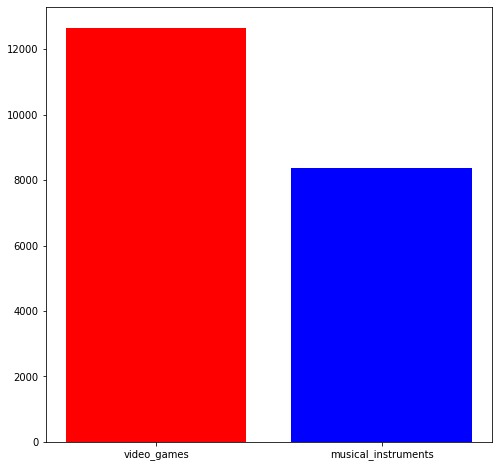



video_games            12658
musical_instruments     8380
Name: product_category, dtype: int64


In [113]:
category_classes = data_filtered.product_category.unique()
category_counts = []

for i in category_classes:
  count = len(data_filtered[data_filtered.product_category==i])
  category_counts.append(count)

plt.figure(figsize=(8, 8))
plt.bar(category_classes,category_counts,color=['red','blue'])
plt.show()

print('\n')
print(data_filtered['product_category'].value_counts())

### ***Rating Score Proportions***

In [114]:
rating_classes = data_filtered.review_score.unique()
rating_counts = []

for i in rating_classes:
  count = len(data_filtered[data_filtered.review_score==i])
  rating_counts.append(count)

print('\n')
print(data_filtered['review_score'].value_counts())



5.0    13653
4.0     3750
3.0     1816
1.0      982
2.0      837
Name: review_score, dtype: int64


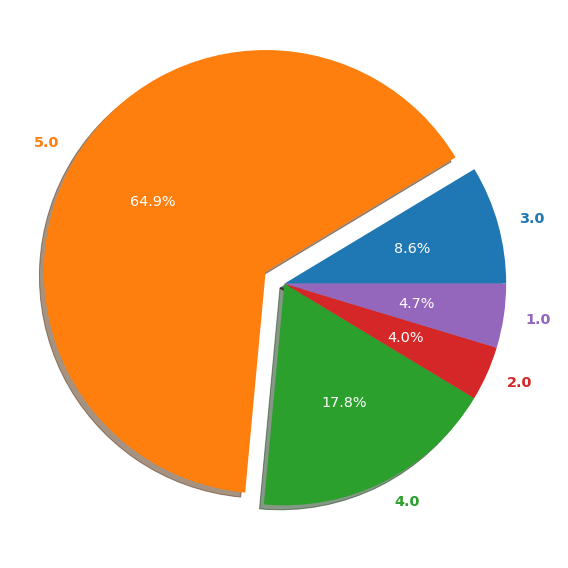

In [115]:
explode = [0, 0.1, 0, 0, 0]
fig, ax = plt.subplots(figsize=(8, 8))

patches, texts, pcts = ax.pie(
    rating_counts, labels=rating_classes, autopct='%.1f%%',
    textprops={'size': 'x-large'}
    ,shadow=True,explode=explode)
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=1000)
plt.tight_layout()

### ***Review Text Distribution***

count    21038.000000
mean        70.767326
std        131.542871
min          1.000000
25%         14.000000
50%         34.000000
75%         73.000000
max       3076.000000
Name: word_count, dtype: float64
51 bins


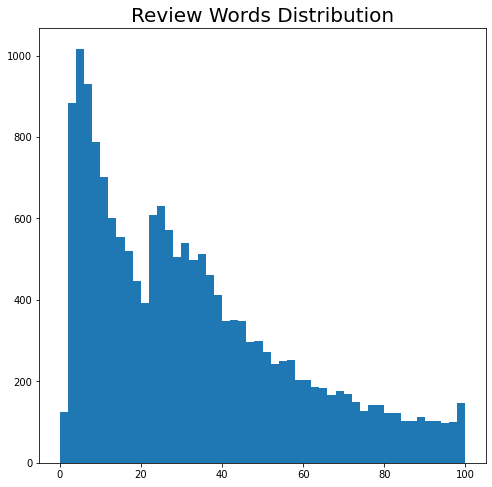

In [116]:
data_filtered['review_len'] = data_filtered['text'].astype(str).apply(len)
data_filtered['word_count'] = data_filtered['text'].apply(lambda x: len(str(x).split()))
print(data_filtered['word_count'].describe())

x_min = 0
x_max = 100
bin_width = 2

n_bins = int((bin_width + x_max - x_min) / bin_width)
print(str(n_bins) + ' bins')
bins = [(x_min + x * (bin_width + x_max - x_min) / n_bins) for x in range(int(n_bins))]

plt.figure(figsize=(8, 8))
plt.hist(data_filtered['word_count'], bins)
plt.title('Review Words Distribution', fontsize=20)
plt.show()

### **Exporting Excluded data**

In [117]:
# from google.colab import drive
# drive.mount('drive')

# deleted = pd.concat([null_values,unverified,duplicated_rows,review_score_nulls])
# print(deleted.shape)

# deleted.to_csv('/content/drive/My Drive/excluded_data.csv', encoding='utf-8', index=False)

# **Text Preprocessing**

In [118]:
processed_data = data_filtered.copy()
processed_data.shape, data.shape

((21038, 7), (32918, 5))

### **Removing Stopwords, Special Characters, emojis, emails, numbers, phone numbers, html tags, punctuations, urls, address**

---

In [119]:
def preprocess(document):
    docx= document.apply(nfx.normalize)
    docx= docx.apply(nfx.remove_puncts)
    docx= docx.apply(nfx.remove_stopwords)
    docx= docx.apply(nfx.remove_html_tags)
    docx= docx.apply(nfx.remove_special_characters)
    docx= docx.apply(nfx.remove_emojis)
    docx= docx.apply(nfx.fix_contractions)
    docx= docx.apply(nfx.remove_emails)
    docx= docx.apply(nfx.remove_numbers)
    docx= docx.apply(nfx.remove_phone_numbers)
    docx= docx.apply(nfx.remove_btc_address)
    docx= docx.apply(nfx.remove_urls)
    return docx.str.lower()

processed_data['clean_reviews'] = preprocess(processed_data['text'])

**Comparing with the original text**

In [120]:
processed_data[['clean_reviews','text']].head()

,clean_reviews,text
3,system burn screen kept going usb mode way fix...,The system had a burn in the screen and kept g...
5,good happy,It's good. Happy To Have It
7,love thx perfect love thx perfect,i love it thx its perfect. i love it thx its p...
8,flimsy thought getting orange ones oh know des...,Flimsy. Thought I was getting the Orange ones....
11,course best perfect controls great original le...,... so of course it's the best. Perfect contro...


In [121]:
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

  return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = nltk.stem.WordNetLemmatizer()
def get_lemmatize(sent):
  return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sent)])

In [122]:
processed_data['review_cleaned_lemmatized'] = processed_data['clean_reviews'].apply(get_lemmatize)

### **Splitting data to test & train sets**

In [123]:
reviews = processed_data['review_cleaned_lemmatized']

label_encoder = preprocessing.LabelEncoder()
 
processed_data['product_category_encoded']= label_encoder.fit_transform(processed_data['product_category'])

category_labels = processed_data['product_category_encoded']
reviews_train,reviews_test,category_train,category_test = train_test_split(reviews,category_labels, test_size=0.2,random_state=42, shuffle=True)


In [124]:
df_five = processed_data[(processed_data['review_score']==5)]
df_four = processed_data[(processed_data['review_score']==4)] 
df_three = processed_data[(processed_data['review_score']==3)] 
df_two = processed_data[(processed_data['review_score']==2)] 
df_one = processed_data[(processed_data['review_score']==1)]



df_five_undersampled = resample(df_five,
                              replace=True,
                              n_samples= 837,
                              random_state=42)  # reproducible results
df_four_undersampled = resample(df_four,
                              replace=True,
                              n_samples= 837,
                              random_state=42)
df_three_undersampled = resample(df_three,
                              replace=True,
                              n_samples= 837,
                              random_state=42)
df_one_undersampled = resample(df_one,
                              replace=True,
                              n_samples= 837,
                              random_state=42)
# Combine majority class with upsampled minority class
df_undersampled = pd.concat([df_one_undersampled, df_three_undersampled,df_five_undersampled,df_four_undersampled, df_two])
print(df_undersampled['review_score'].value_counts())

rating_labels = df_undersampled['review_score']
reviews_train_star,reviews_test_star,rating_train,rating_test = train_test_split(df_undersampled['review_cleaned_lemmatized'],rating_labels, test_size=0.20,random_state=42, shuffle=True)


1.0    837
3.0    837
5.0    837
4.0    837
2.0    837
Name: review_score, dtype: int64


# **1st Method (Logistic Regression)**

### **Creating a Pipeline**

In [125]:
logreg_rating = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression( max_iter=500,multi_class='multinomial', solver='lbfgs')),
               ])

logreg_category = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=1, max_iter=500, solver='saga')),
               ])

## **Product Category Prediction**

### ***Training Set***

Accuracy: 0.967, Precision: 0.974, Recall: 0.971, F1 Score: 0.972


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


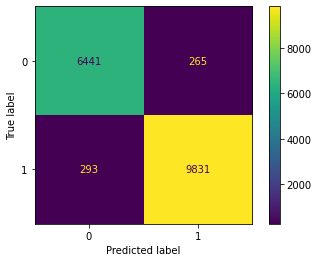

In [126]:
logistic_model_category = logreg_category.fit(reviews_train,category_train)
category_prediction_train = logistic_model_category.predict(reviews_train)
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(category_train, category_prediction_train), 
                                                                                        precision_score(category_train, category_prediction_train,average="binary"), 
                                                                                        recall_score(category_train, category_prediction_train,average="binary"), 
                                                                                        f1_score(category_train, category_prediction_train,average="binary")))
plot_confusion_matrix(logistic_model_category,reviews_train,category_train)

### ***Testing Set***

In [127]:
category_prediction_test = logistic_model_category.predict(reviews_test)

### **Confusion Matrix**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


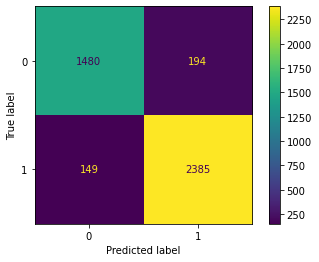

In [128]:
plot_confusion_matrix(logistic_model_category,reviews_test,category_test)

### **Classification Report**

In [129]:
print(classification_report(category_test,category_prediction_test))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1674
           1       0.92      0.94      0.93      2534

    accuracy                           0.92      4208
   macro avg       0.92      0.91      0.91      4208
weighted avg       0.92      0.92      0.92      4208



### **ROC Curve**

In [130]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def roc_classifier(grid, X_train, y_train, X_test, y_test):
    # predict probabilities
    lr_probs_train = grid.predict_proba(X_train)
    lr_probs_test = grid.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs_train = lr_probs_train[:, 1]
    lr_probs_test = lr_probs_test[:, 1]

    print('ROC AUC (Training)={:.3f}'.format(roc_auc_score(y_train, lr_probs_train,multi_class='ovo')))
    print('ROC AUC (Testing)={:.3f}'.format(roc_auc_score(y_test, lr_probs_test,multi_class='ovo')))

    # compute false positive and true positive rates
    lr_fpr_train, lr_tpr_train, _ = roc_curve(y_train, lr_probs_train)
    lr_fpr_test, lr_tpr_test, _ = roc_curve(y_test, lr_probs_test)

    # plot the roc curve for the training set
    _ = plt.figure(figsize=(15, 5))
    ax1 =plt.subplot(121)
    _ = ax1.plot(lr_fpr_train, lr_tpr_train, marker='x')
    _ = ax1.plot([0,1], [0, 1], 'gray', linestyle=':', marker='')
    _ = ax1.set_title('Receiver Operating Characteristics (ROC) - Training')
    _ = ax1.set_xlabel('False Positive Rate')
    _ = ax1.set_ylabel('True Positive Rate')

    # plot the roc curve for the testing set
    ax2 = plt.subplot(122)
    _ = ax2.plot(lr_fpr_test, lr_tpr_test, marker='x')
    _ = ax2.plot([0,1], [0, 1], 'gray', linestyle=':', marker='')
    _ = ax2.set_title('Receiver Operating Characteristics (ROC) - Testing')
    _ = ax2.set_xlabel('False Positive Rate')
    _ = ax2.set_ylabel('True Positive Rate')

    return (lr_probs_train, lr_fpr_train, lr_tpr_train, 
            lr_probs_test,  lr_fpr_test, lr_tpr_test)


### **ROC Curve for Product Category**

ROC AUC (Training)=0.993
ROC AUC (Testing)=0.976


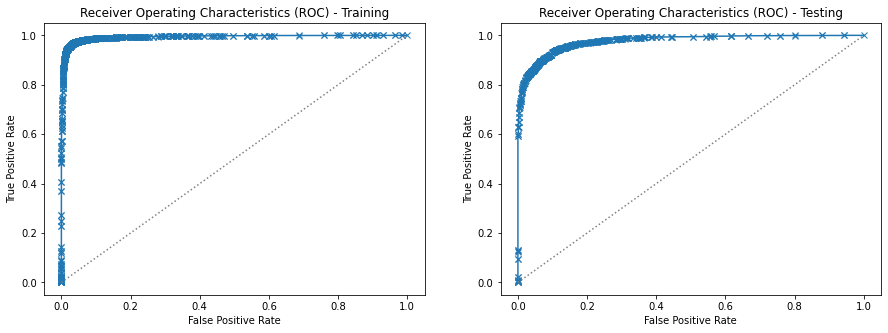

In [131]:
lr_probs_train, lr_fpr_train, lr_tpr_train, lr_probs_test, lr_fpr_test, lr_tpr_test = roc_classifier(
                                                                    logistic_model_category, reviews_train, category_train, reviews_test, category_test)

## **Star Rating Prediction**

In [132]:
logistic_model_rating = logreg_rating.fit(reviews_train_star, rating_train)

### ***Training Set***

In [133]:
rating_prediction_train = logistic_model_rating.predict(reviews_train_star)

### **Confusion Matrix**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


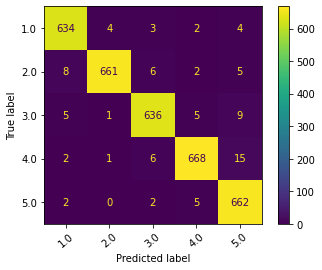

In [134]:
plot_confusion_matrix(logistic_model_rating,reviews_train_star,rating_train,xticks_rotation=40)

### **Classification Report**

In [135]:
print(classification_report(rating_prediction_train,rating_train))

              precision    recall  f1-score   support

         1.0       0.98      0.97      0.98       651
         2.0       0.97      0.99      0.98       667
         3.0       0.97      0.97      0.97       653
         4.0       0.97      0.98      0.97       682
         5.0       0.99      0.95      0.97       695

    accuracy                           0.97      3348
   macro avg       0.97      0.97      0.97      3348
weighted avg       0.97      0.97      0.97      3348



### ***Testing Set***

Accuracy: 0.56, Precision: 0.56, Recall: 0.56, F1 Score: 0.56
              precision    recall  f1-score   support

         1.0       0.69      0.75      0.72       175
         2.0       0.46      0.41      0.43       177
         3.0       0.51      0.59      0.55       157
         4.0       0.52      0.46      0.49       163
         5.0       0.58      0.59      0.59       165

    accuracy                           0.56       837
   macro avg       0.55      0.56      0.56       837
weighted avg       0.56      0.56      0.56       837



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


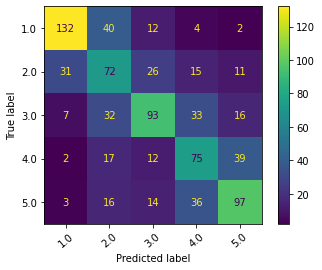

In [136]:
rating_prediction_test = logistic_model_rating.predict(reviews_test_star)

print('Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}'.format(accuracy_score(rating_test, rating_prediction_test), 
                                                                                        precision_score(rating_test, rating_prediction_test,average='micro'), 
                                                                                        recall_score(rating_test, rating_prediction_test,average='micro'), 
                                                                                        f1_score(rating_test, rating_prediction_test,average='micro')))
plot_confusion_matrix(logistic_model_rating,reviews_test_star,rating_test,xticks_rotation=40)

print(classification_report(rating_prediction_test,rating_test))

## **Evaluation**

In [170]:
def get_models():
	models = dict()
	for p in [0.01, 0.1, 1.0]:
		# create name for model
		key = '%.4f' % p
		# turn off penalty in some cases
		if p == 0.0:
			# no penalty in this case
			models[key] = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(multi_class='multinomial', max_iter=500, solver='lbfgs', penalty='none')),
               ])
		else:
			models[key] = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(multi_class='multinomial', max_iter=500, solver='lbfgs', penalty='l2', C=p)),
               ])
	return models


In [171]:
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

In [172]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = evaluate_model(model, reviews_test_star,rating_test)
	# store the results
	results.append(scores)
	names.append(name)
 

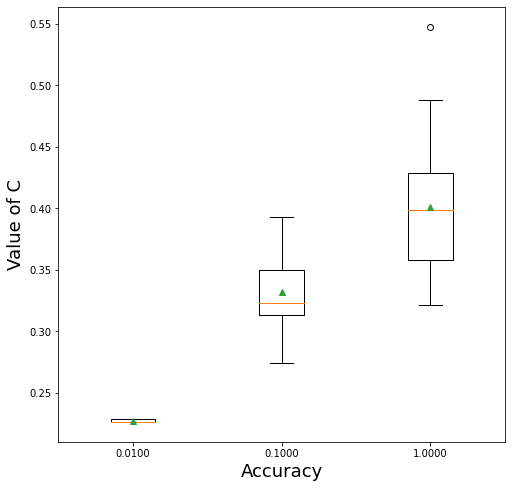

In [174]:
plt.figure(figsize=(8, 8))
# data[selected].boxplot()
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel('Accuracy', fontsize=18)
plt.ylabel('Value of C', fontsize=18)
plt.show()

Evaluatin

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(data_filtered['text'], data_filtered['review_score'].values, test_size=0.2)
grid=[{'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
       'C' : np.logspace(-4, 4,20),
       'solver':['liblinear'],
       'max_iter' : [10,100, 1000,2500, 5000]
    }]
    
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
      
logreg =  LogisticRegression()

lr = GridSearchCV(logreg, param_grid = grid, cv = 5, scoring='accuracy', verbose = 1, n_jobs = -1)
best_model = lr.fit(X_train, y_train)

print(best_model.best_estimator_)
print(best_model.best_score_)

y_pred_grid = best_model.predict(y_test)
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))
print(accuracy_score(y_test, y_pred_grid))

#LogisticRegression(C=1, max_iter=500))
#LogisticRegression(C=1, max_iter=500, solver='saga')

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


# **Evaluation of the Models**

In [ ]:
def predict_Logisitic_Model(evaluation_data):
  category_prediction_v = logistic_model_category.predict(evaluation_data['review_cleaned_lemmatized'])
  rating_prediction_v = logistic_model_rating.predict(evaluation_data['review_cleaned_lemmatized'])
  print("Logistic Regression Model: ")
  print("/n Predicted Rating: ")
  print(rating_prediction_v)
  print(" Actual Rating: ")
  print(evaluation_data['review_score'].values)
  print("/n Predicted Category: ")
  print(category_prediction_v)
  print(" Actual Category: ")
  print(evaluation_data['product_category_encoded'].values)
  print("Accuracy for Categories: "+ str((accuracy_score(evaluation_data['product_category_encoded'],category_prediction_v))*100))
  print("Accuracy for Ratings: "+ str((accuracy_score(evaluation_data['review_score'],rating_prediction_v)*100)))

In [ ]:
evaluation_data = reviews_test_star.sample(10)
index = evaluation_data.index
test_data =pd.DataFrame()
for i in index:
  test_data = test_data.append(df_undersampled[df_undersampled.index == i])
  test_data = test_data.drop_duplicates()
predict_Logisitic_Model(test_data)

# **Bert**

## **Star Rating Prediction**

In [ ]:
label_encoder = preprocessing.LabelEncoder()

df_five = data_filtered[(data_filtered['review_score']==5)]
df_four = data_filtered[(data_filtered['review_score']==4)] 
df_three = data_filtered[(data_filtered['review_score']==3)] 
df_two = data_filtered[(data_filtered['review_score']==2)] 
df_one = data_filtered[(data_filtered['review_score']==1)]

df_five_undersampled = resample(df_five,
                              replace=True,
                              n_samples= 837,
                              random_state=42)  # reproducible results
df_four_undersampled = resample(df_four,
                              replace=True,
                              n_samples= 837,
                              random_state=42)
df_three_undersampled = resample(df_three,
                              replace=True,
                              n_samples= 837,
                              random_state=42)
df_one_undersampled = resample(df_one,
                              replace=True,
                              n_samples= 837,
                              random_state=42)
# Combine majority class with upsampled minority class
df_undersampled = pd.concat([df_one_undersampled, df_three_undersampled,df_five_undersampled,df_four_undersampled, df_two])
df_undersampled['review_score'].value_counts()
df_undersampled['review_score_encoded']= label_encoder.fit_transform(df_undersampled['review_score'])

In [ ]:
x_star_train, x_star_test, y_star_train, y_star_test = train_test_split(df_undersampled['text'],df_undersampled['review_score_encoded'], test_size = 0.2)

In [ ]:
model_args_star = ClassificationArgs()
model_args_star.num_train_epochs = 10
model_args_star.learning_rate = 1e-4
model_args_star.train_batch_size = 32
model_args_star.eval_batch_size = 32
model_args_star.overwrite_output_dir = True
model_args_star.optimizer = 'AdamW'
model_args_star.do_lower_case = True

In [ ]:
bert_star_model = ClassificationModel("bert", "bert-base-cased",num_labels = 5,args=model_args_star,use_cuda=True)

In [ ]:
train_df_star = pd.DataFrame({"text":x_star_train, "labels":y_star_train})
eval_df_star = pd.DataFrame({"text":x_star_test, "labels":y_star_test})

In [ ]:
bert_star_model.train_model(train_df_star, acc=accuracy_score)

In [ ]:
result_star, model_outputs_star, wrong_predictions_star = bert_star_model.eval_model(eval_df_star, acc=accuracy_score)

In [ ]:
result_star

In [ ]:
x_star_testval = np.array(x_star_test.values)
listoftestvalues_star = x_star_testval.tolist()
preds_star, model_ouputs_star = bert_star_model.predict(listoftestvalues_star)
preds_star,model_ouputs_star

In [ ]:
accuracy_score(y_star_test,preds_star)

In [ ]:
def predict_rating(review_text):
  output_rating = bert_star_model.predict([review_text])
  if (output_rating[0] == 0):
    rating = '1'
  elif(output_rating[0] == 1):
    rating ='2'
  elif(output_rating[0] == 2):
    rating = '3'
  elif(output_rating[0] == 3):
    rating = '4'
  else:
    rating = '5'
  print(rating)

predict_rating("There’s dinks and paint marks on it, but let’s face it, it’s very cheap for what it is. Once the nylon strings settle (you’ll have to keep tuning it for a few days), it’s perfectly fine. I have nothing to complain about at this price point. If I wanted a proper instrument, I wouldn’t be buying it from Amazon.")

## **Product Category Prediction**

In [ ]:
label_encoder = preprocessing.LabelEncoder()
 
data_filtered['product_category_encoded']= label_encoder.fit_transform(data_filtered['product_category'])

df_video = data_filtered[(data_filtered['product_category_encoded']==1)]
df_music = data_filtered[(data_filtered['product_category_encoded']==0)]
df_minority_upsampled = resample(df_music, 
                                 replace=True,
                                 n_samples= 12476,
                                 random_state=42) 


df_oversampled = pd.concat([df_minority_upsampled, df_video])
df_oversampled['product_category_encoded'].value_counts()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_oversampled['text'],df_oversampled['product_category_encoded'], test_size = 0.2)

In [ ]:
model_args = ClassificationArgs()
model_args.num_train_epochs = 5
model_args.learning_rate = 1e-4
model_args.train_batch_size = 32
model_args.eval_batch_size = 32
model_args.overwrite_output_dir = True

In [ ]:
bert_model = ClassificationModel("bert", "bert-base-cased",num_labels = 2,args=model_args,use_cuda=True)

In [ ]:
train_df = pd.DataFrame({"text":x_train, "labels":y_train})
eval_df = pd.DataFrame({"text":x_test, "labels":y_test})

In [ ]:
bert_model.train_model(train_df, acc=accuracy_score)

In [ ]:
result, model_outputs, wrong_predictions = bert_model.eval_model(eval_df, acc=accuracy_score)

In [ ]:
result

In [ ]:
x_testval = np.array(x_test.values)
listoftestvalues = x_testval.tolist()
preds, model_ouputs = bert_model.predict(listoftestvalues)

In [ ]:
preds

In [ ]:
def predict_category(review_text):
  output_category = bert_model.predict([review_text])
  if (output_category[0] == 1):
    category = 'Video Games'
  else:
    category = 'Muscial Instrument'
  print(category)

predict_category('Bought for my daughter who has shown great piano playing skills on a phone app with limited keys. This blew her away, she was so very happy to receive this gift. Easy to set up, open the box, take it out, put the stand and stool/seat together (both very easy), fix the keyboard to the stand (so it doesn\'t slip off), plug it in and start playing. Looks very nice lit up with the blue screen which shows you what instrument you are playing. Lots of combinations of instruments, backing, beats, noises, clapping, various other noises and sounds so you can really get creative and have lots of musical fun. Longer sound with use of the pedal. Headphones plug in nicely. One good thing is that the piano sound is a lovely piano sound, not like an electric piano, sounds like a nice real piano. The keys have a nice bounce to them. You can record ONE song/play of your music and play it back. We really do like it a lot.')